# 4 利用Pytorch实现softmax回归的简洁实现

In [1]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

2.0.1+cu118
cuda


## 4.1 加载图像分类数据集（Fashion-MNIST）

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='./dataset/FashionMNIST', train=True, download=False, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='./dataset/FashionMNIST', train=False, download=False, transform=transforms.ToTensor())

In [3]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

<class 'torchvision.datasets.mnist.FashionMNIST'>
60000 10000


In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_fashion_mnist(images, labels):
    d2l.use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

C:\Users\crc\AppData\Local\Temp\ipykernel_4404\1295271808.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


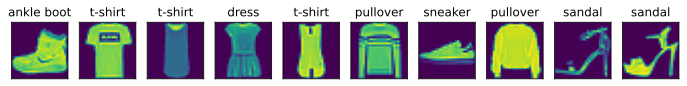

In [5]:
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
from IPython import display
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')
def show_fashion_mnist(images, labels):
    use_svg_display()
    # 杩欓噷鐨刜琛ㄧず鎴戜滑蹇界暐锛堜笉浣跨敤锛夌殑鍙橀噺
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 4.2 获取和读取数据
可选择不同的batch_size

In [6]:
batch_size = 256
num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

## 4.3 定义和初始化模型

In [7]:
num_inputs = 784
num_outputs = 10

# #定义模型（添加）
# class LinearNet(nn.Module):
#     def __init__(self, num_inputs, num_outputs):
        
#     def init_weights(self):
    
#     def forward(self, x): # x shape: (batch, 1, 28, 28)
        


class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()

        self.fc = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        output = self.fc(x)
        return output


# 初始化模型和损失函数
net = LinearNet(num_inputs, num_outputs).to(device)

In [8]:
#输出初始化的参数（添加）
for name, param in net.named_parameters():
    if 'weight' in name:
        print(f'Parameter {name}: {param}')

Parameter fc.weight: Parameter containing:
tensor([[ 0.0127,  0.0331, -0.0242,  ...,  0.0047, -0.0199,  0.0106],
        [ 0.0100,  0.0052, -0.0332,  ..., -0.0149, -0.0187, -0.0262],
        [ 0.0310, -0.0253,  0.0191,  ...,  0.0233, -0.0041, -0.0040],
        ...,
        [-0.0310,  0.0276,  0.0311,  ...,  0.0050, -0.0118, -0.0313],
        [-0.0076, -0.0031,  0.0314,  ..., -0.0135,  0.0255,  0.0044],
        [ 0.0299, -0.0122,  0.0043,  ..., -0.0317,  0.0213, -0.0205]],
       device='cuda:0', requires_grad=True)


## 4.4 softmax和交叉熵损失函数

In [9]:
loss = nn.CrossEntropyLoss().to(device)


def softmax(X):  # softmax计算
    X_exp = X.exp()  # 对每个元素做指数运算
    partition = X_exp.sum(dim=1, keepdim=True)  # 求列和，即对同行元素求和 n*1
    return X_exp / partition  # broadcast

## 4.5 定义优化算法
可选择多种优化算法训练模型(查官网资料)

可选择不同的学习率

In [10]:
learning_rate = 0.05
# optimizer = optim.SGD(net.parameters(), lr=learning_rate)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)# Adam梯度下降
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.05
    maximize: False
    weight_decay: 0
)


## 4.6 训练模型

## 定义评价函数代码

In [11]:
def evaluate_accuracy(data_iter, net, device=None):
    if device is None and isinstance(net, torch.nn.Module):
        # 如果没指定device就使用net的device
        device = list(net.parameters())[0].device 
    acc_sum, n = 0.0, 0
    with torch.no_grad():
        for X, Y in data_iter:
            X = X.to(device)
            Y = Y.to(device)
            if isinstance(net, torch.nn.Module):
                net.eval() # 评估模式, 这会关闭dropout
                acc_sum += (net(X.to(device)).argmax(dim=1) == Y).float().sum().cpu().item()
                net.train() # 改回训练模式
            else: # 自定义的模型, 3.13节之后不会用到, 不考虑GPU
                if('is_training' in net.__code__.co_varnames): # 如果有is_training这个参数
                    # 将is_training设置成False
                    acc_sum += (net(X, is_training=False).argmax(dim=1) == Y).float().sum().item() 
                else:
                    acc_sum += (net(X).argmax(dim=1) == Y).float().sum().item() 
            n += Y.shape[0]
    return acc_sum / n

## 模型训练过程 代码（添加）
可选择不同epoch大小
训练过程代码自行添加

In [12]:
num_epochs = 50

losses = []
accuracies_train = []
accuracies_test = []
    
    
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, Y in train_iter:
        X = X.to(device)
        Y = Y.to(device)
        output = net(X)
        temp = torch.zeros(len(Y), 10)
        temp = temp.to(device)
        for i,label in enumerate(Y):
            temp[i, label] = 1
        Y = temp # 对标签进行重构，变为独热编码
        l = loss(output, Y)
        optimizer.zero_grad() #清除梯度
        l.backward()
        optimizer.step() #更新网络参数
        train_l_sum += l
        losses.append(l.item())
        n += 1

    # 在训练集和测试集上计算准确率，记录训练过程中的损失和准确率
    train_acc = evaluate_accuracy(train_iter, net, "cuda")
    test_acc = evaluate_accuracy(test_iter, net, "cuda")
    accuracies_train.append(train_acc)
    accuracies_test.append(test_acc)
    
    print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
          % (epoch + 1, train_l_sum / n, train_acc , test_acc))

epoch 1, loss 0.7890, train acc 0.749, test acc 0.732
epoch 2, loss 0.5983, train acc 0.834, test acc 0.815
epoch 3, loss 0.5961, train acc 0.853, test acc 0.832
epoch 4, loss 0.6081, train acc 0.859, test acc 0.837
epoch 5, loss 0.5695, train acc 0.832, test acc 0.812
epoch 6, loss 0.6040, train acc 0.830, test acc 0.803
epoch 7, loss 0.5904, train acc 0.816, test acc 0.794
epoch 8, loss 0.5819, train acc 0.806, test acc 0.790
epoch 9, loss 0.6093, train acc 0.840, test acc 0.812
epoch 10, loss 0.5972, train acc 0.840, test acc 0.816
epoch 11, loss 0.5805, train acc 0.825, test acc 0.800
epoch 12, loss 0.6371, train acc 0.848, test acc 0.820
epoch 13, loss 0.5995, train acc 0.842, test acc 0.815
epoch 14, loss 0.6232, train acc 0.824, test acc 0.796
epoch 15, loss 0.5900, train acc 0.812, test acc 0.782
epoch 16, loss 0.5976, train acc 0.852, test acc 0.820
epoch 17, loss 0.5899, train acc 0.833, test acc 0.801
epoch 18, loss 0.5757, train acc 0.853, test acc 0.824
epoch 19, loss 0.57

## 4.7 训练过程可视化
参考线性回归的代码展现可视化过程，loss以及准确率的变化图

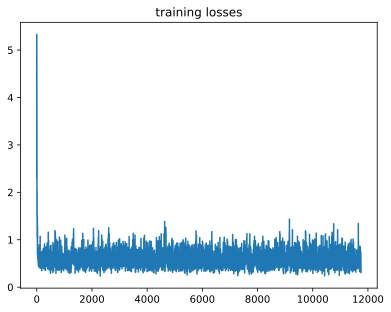

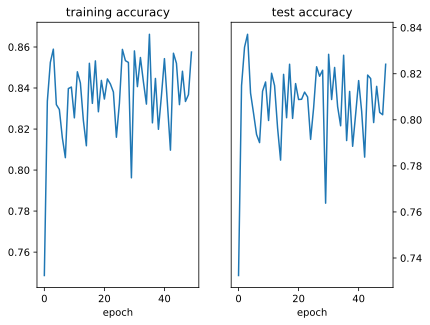

In [13]:
# 训练过程可视化
plt.plot(losses)
plt.title("training losses")
plt.savefig("./results/loss.png") # 保存loss图片
plt.show()
plt.subplot(121) # 创建子图1
plt.plot(accuracies_train)
plt.title("training accuracy")
plt.xlabel("epoch")
plt.subplot(122)  # 创建子图2
plt.plot(accuracies_test)
plt.title("test accuracy")
plt.xlabel("epoch")
ax=plt.gca()
ax.yaxis.tick_right()
plt.savefig("./results/accuracy.png")

In [14]:
print(max(accuracies_train))
print(min(accuracies_train))
print(max(accuracies_test))
print(min(accuracies_test))

0.8661833333333333
0.7486
0.8371
0.7324
